# Can we build an ensemble model to help us make a profit? Should this model use a running window or is the nature of gold prices static? These are some of the many questions that we will hope to answer.
## Table of Contents

In [1]:
import pandas as pd 
import numpy as np
#Regular expressions for fine-tuned searching
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import re
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import datetime
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV, cross_validate, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv("financial_regression.csv")

Let's take a look at our dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 open          3719 non-null   float64
 2   sp500 high          3719 non-null   float64
 3   sp500 low           3719 non-null   float64
 4   sp500 close         3719 non-null   float64
 5   sp500 volume        3719 non-null   float64
 6   sp500 high-low      3719 non-null   float64
 7   nasdaq open         3719 non-null   float64
 8   nasdaq high         3719 non-null   float64
 9   nasdaq low          3719 non-null   float64
 10  nasdaq close        3719 non-null   float64
 11  nasdaq volume       3719 non-null   float64
 12  nasdaq high-low     3719 non-null   float64
 13  us_rates_%          176 non-null    float64
 14  CPI                 176 non-null    float64
 15  usd_chf             3694 non-null   float64
 16  eur_us

In [4]:
df.head(3)

,date,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq open,nasdaq high,nasdaq low,...,palladium high,palladium low,palladium close,palladium volume,palladium high-low,gold open,gold high,gold low,gold close,gold volume
0,2010-01-14,114.49,115.14,114.42,114.93,115646960.0,0.72,46.26,46.52,46.22,...,45.02,43.86,44.84,364528.0,1.16,111.51,112.37,110.79,112.03,18305238.0
1,2010-01-15,114.73,114.84,113.20,113.64,212252769.0,1.64,46.46,46.55,45.65,...,45.76,44.40,45.76,442210.0,1.36,111.35,112.01,110.38,110.86,18000724.0
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### As you can see, the close price of an index on one day does not equal the open price of the same index on the following day. In order to account for the change in price after trading hours, we will look at the log returns of the close/open prices only. We will choose to use log returns of closing prices, a running standard deviation value of the same day volume, and the percent difference of high/low. This will allow us to keep as many variables as possible. We will however need to determine if we will be overfitting due to high variable count.
#### Let us determine first how much cleaning we will have to do first.

In [5]:
#Drop the open prices
df = df.drop([col for col in df.columns if 'open' in col], axis=1)

In [6]:
df.head(4)

,date,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq high,nasdaq low,nasdaq close,nasdaq volume,...,platinum high-low,palladium high,palladium low,palladium close,palladium volume,palladium high-low,gold high,gold low,gold close,gold volume
0,2010-01-14,115.14,114.42,114.93,115646960.0,0.72,46.52,46.22,46.39,75209000.0,...,2.1300,45.02,43.86,44.84,364528.0,1.16,112.37,110.79,112.03,18305238.0
1,2010-01-15,114.84,113.20,113.64,212252769.0,1.64,46.55,45.65,45.85,126849300.0,...,1.7500,45.76,44.40,45.76,442210.0,1.36,112.01,110.38,110.86,18000724.0
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-19,115.13,113.59,115.06,138671890.0,1.54,46.64,45.95,46.59,84388200.0,...,3.0278,47.08,45.70,46.94,629150.0,1.38,111.75,110.83,111.52,10467927.0


#### The high - low columns do not reflect change relative to stock price. A better alternative is to use percent difference, or log return in our case

In [7]:
#Let's attain the list of unique asssets that have closing price. This will exclude GDP, etc. that does not have low/high.
unique_assets = [re.findall(r"^(.*?)(?=\sclose)", c)[0] for c in df.columns if "close" in c]
print(unique_assets)

['sp500', 'nasdaq', 'silver', 'oil', 'platinum', 'palladium', 'gold']


In [8]:
df_temp = df.copy()

In [9]:
#For each asset that has low/high: create a column that represents the division of high/low for same day:
for a in unique_assets:
    df.loc[:,f"{a} high/low"] = np.log(df.loc[:, f"{a} high"]/df.loc[:,f"{a} low"])

In [10]:
df.head(3)

,date,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq high,nasdaq low,nasdaq close,nasdaq volume,...,gold low,gold close,gold volume,sp500 high/low,nasdaq high/low,silver high/low,oil high/low,platinum high/low,palladium high/low,gold high/low
0,2010-01-14,115.14,114.42,114.93,115646960.0,0.72,46.52,46.22,46.39,75209000.0,...,110.79,112.03,18305238.0,0.006273,0.006470,0.013459,0.014301,0.013248,0.026104,0.014160
1,2010-01-15,114.84,113.20,113.64,212252769.0,1.64,46.55,45.65,45.85,126849300.0,...,110.38,110.86,18000724.0,0.014384,0.019523,0.009756,0.019147,0.010912,0.030171,0.014659
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we can drop the low/high columns, as that information is already represented in the division columns

In [11]:
df = df.drop([col for col in df.columns if re.match(r"(.*\s(high|low|high-low)$)", col)], axis=1)

In [55]:
#df = df.drop([col for col in df.columns if re.match(r"(.*\s(high|low|high-low)$)", col)], axis=1)

### Our new dataset looks like so:

In [12]:
df.head(3)

,date,sp500 close,sp500 volume,nasdaq close,nasdaq volume,us_rates_%,CPI,usd_chf,eur_usd,GDP,...,palladium volume,gold close,gold volume,sp500 high/low,nasdaq high/low,silver high/low,oil high/low,platinum high/low,palladium high/low,gold high/low
0,2010-01-14,114.93,115646960.0,46.39,75209000.0,NaN,NaN,1.0206,1.4478,NaN,...,364528.0,112.03,18305238.0,0.006273,0.006470,0.013459,0.014301,0.013248,0.026104,0.014160
1,2010-01-15,113.64,212252769.0,45.85,126849300.0,NaN,NaN,1.0264,1.4376,NaN,...,442210.0,110.86,18000724.0,0.014384,0.019523,0.009756,0.019147,0.010912,0.030171,0.014659
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 close         3719 non-null   float64
 2   sp500 volume        3719 non-null   float64
 3   nasdaq close        3719 non-null   float64
 4   nasdaq volume       3719 non-null   float64
 5   us_rates_%          176 non-null    float64
 6   CPI                 176 non-null    float64
 7   usd_chf             3694 non-null   float64
 8   eur_usd             3694 non-null   float64
 9   GDP                 57 non-null     float64
 10  silver close        3719 non-null   float64
 11  silver volume       3719 non-null   float64
 12  oil close           3719 non-null   float64
 13  oil volume          3719 non-null   float64
 14  platinum close      3719 non-null   float64
 15  platinum volume     3719 non-null   float64
 16  pallad

In [14]:
non_asset_columns = [col for col in df.columns if "close" not in col and "volume" not in col and "high/low" not in col]
print(non_asset_columns)

['date', 'us_rates_%', 'CPI', 'usd_chf', 'eur_usd', 'GDP']


It's best to keep information regarding the difference in non_asset data such as CPI relative to when it was first available. We will call this "shock". Applying a log return allows to take advantage of the additive properties of logarithms.

Now let's update the date column to be type 'datetime'

In [15]:
df['date'] =df['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

As we can see, rates, CPI, and GDP are mostly nulls. What can we do about these to keep some of the info intact?

In [383]:
df[non_asset_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3904 non-null   datetime64[ns]
 1   us_rates_%  176 non-null    float64       
 2   CPI         176 non-null    float64       
 3   usd_chf     3694 non-null   float64       
 4   eur_usd     3694 non-null   float64       
 5   GDP         57 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 183.1 KB


In [16]:
df[non_asset_columns].query("GDP.notnull()").head(4)

,date,us_rates_%,CPI,usd_chf,eur_usd,GDP
55,2010-04-01,0.20,217.403,1.0559,1.3569,14980.193
121,2010-07-01,0.18,217.605,1.0675,1.2464,15141.607
188,2010-10-01,0.19,219.035,0.9761,1.3754,15309.474
254,2011-01-01,0.17,221.187,NaN,NaN,15351.448


In [17]:
df_temp = df.copy()

In [18]:
df = df_temp.copy()

In [453]:
"""non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]
df[[col+"_interpolated" for col in non_asset_date_columns]] =df[non_asset_date_columns].interpolate()
df[[col for col in df.columns if "interpolated" in col]] = df[[col for col in df.columns if "interpolated" in col]].interpolate(limit_direction="backward")"""

'non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]\ndf[[col+"_interpolated" for col in non_asset_date_columns]] =df[non_asset_date_columns].interpolate()\ndf[[col for col in df.columns if "interpolated" in col]] = df[[col for col in df.columns if "interpolated" in col]].interpolate(limit_direction="backward")'

We can also have columns representing CPI, usd_chf, eur_usd of latest available data by forward-filling. This will look reminiscent to a square wave (_ - _) and will allow us to calculate percent log returns (or shock)

Let's bring forward all known non-asset values to fill NULLs.

In [21]:
non_asset_columns = [col for col in df.columns if "close" not in col and "volume" not in col and "high/low" not in col]
non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]
df[non_asset_columns] = df[non_asset_columns].ffill()

Also note that there is one currency relationship that is USD over CHF, and another where it is the divisor (EUR). Let's make it inverse.

In [19]:
df['usd_eur'] = 1/df['eur_usd']

In [20]:
df = df.drop("eur_usd", axis=1)

In [22]:
df[non_asset_date_columns]/df[non_asset_date_columns].shift(1)

,us_rates_%,CPI,usd_chf,GDP,usd_eur
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.005683,NaN,1.007095
2,NaN,NaN,1.000000,NaN,1.000000
3,NaN,NaN,1.007405,NaN,1.007499
4,NaN,NaN,1.010928,NaN,1.012417
...,...,...,...,...,...
3899,1.0,1.0,1.001389,1.0,1.003322
3900,1.0,1.0,1.000578,1.0,0.998434
3901,1.0,1.0,1.000000,1.0,1.000000
3902,1.0,1.0,1.000000,1.0,1.000000


In [23]:
df[[col+"_shock" for col in non_asset_date_columns]] = np.log(df[non_asset_date_columns]/df[non_asset_date_columns].shift(1))

Note that inflation affects both GDP, CPI, and S&P. Let's look at the relationship between the S&P and various non asset values such as CPI. 

It's time to make the data representing previous day returns. But first, we should drop all rows that have nulls

In [460]:
df_2 = df.copy()

In [360]:
df = df_2.copy()

In [28]:
df = df.dropna()

In [30]:
asset_close_columns = [col for col in df.columns if "close" in col]
asset_volume_columns = [col for col in df.columns if "volume" in col]

In [31]:
asset_close_columns = [col for col in df.columns if "close" in col]
asset_volume_columns = [col for col in df.columns if "volume" in col]

df[[col + " change" for col in asset_close_columns]] = np.log(df[asset_close_columns]/df[asset_close_columns].shift(1))
df[[col + " change" for col in asset_volume_columns]] = np.log(df[asset_volume_columns]/df[asset_volume_columns].shift(1))

In [32]:
df = df.dropna()

Now we have a number of columns. We have no use for the absolute volume/ and price, high/low values, as we will avoid overfitting. So let's drop these.

In [33]:
df.columns

Index(['date', 'sp500 close', 'sp500 volume', 'nasdaq close', 'nasdaq volume',
       'us_rates_%', 'CPI', 'usd_chf', 'GDP', 'silver close', 'silver volume',
       'oil close', 'oil volume', 'platinum close', 'platinum volume',
       'palladium close', 'palladium volume', 'gold close', 'gold volume',
       'sp500 high/low', 'nasdaq high/low', 'silver high/low', 'oil high/low',
       'platinum high/low', 'palladium high/low', 'gold high/low', 'usd_eur',
       'us_rates_%_shock', 'CPI_shock', 'usd_chf_shock', 'GDP_shock',
       'usd_eur_shock', 'sp500 close change', 'nasdaq close change',
       'silver close change', 'oil close change', 'platinum close change',
       'palladium close change', 'gold close change', 'sp500 volume change',
       'nasdaq volume change', 'silver volume change', 'oil volume change',
       'platinum volume change', 'palladium volume change',
       'gold volume change'],
      dtype='object')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3664 entries, 58 to 3903
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     3664 non-null   datetime64[ns]
 1   sp500 close              3664 non-null   float64       
 2   sp500 volume             3664 non-null   float64       
 3   nasdaq close             3664 non-null   float64       
 4   nasdaq volume            3664 non-null   float64       
 5   us_rates_%               3664 non-null   float64       
 6   CPI                      3664 non-null   float64       
 7   usd_chf                  3664 non-null   float64       
 8   GDP                      3664 non-null   float64       
 9   silver close             3664 non-null   float64       
 10  silver volume            3664 non-null   float64       
 11  oil close                3664 non-null   float64       
 12  oil volume               3664 non-null

In [37]:
df.isna().sum().sum()

0

In [38]:
#Drop the first row
#df = df.dropna()

In [39]:
df.describe()

,date,sp500 close,sp500 volume,nasdaq close,nasdaq volume,us_rates_%,CPI,usd_chf,GDP,silver close,...,platinum close change,palladium close change,gold close change,sp500 volume change,nasdaq volume change,silver volume change,oil volume change,platinum volume change,palladium volume change,gold volume change
count,3664,3664.000000,3.664000e+03,3664.000000,3.664000e+03,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,...,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000
mean,2017-07-13 11:43:53.187772928,271.124713,1.110859e+08,183.469777,4.454366e+07,1.205592,253.962069,0.945545,20523.493852,21.498305,...,-0.000164,0.000180,0.000223,-0.000218,-0.000105,0.000548,-0.000317,0.000329,-0.000234,-0.000010
min,2010-04-06 00:00:00,102.200000,2.027001e+07,42.470000,7.079300e+06,0.050000,217.199000,0.729600,14980.193000,11.640000,...,-0.144248,-0.219713,-0.091905,-1.517486,-1.499602,-2.890213,-1.898114,-3.131062,-3.853822,-1.642912
25%,2013-11-20 18:00:00,178.085000,6.660698e+07,83.912500,2.707508e+07,0.090000,234.100000,0.911475,17192.019000,16.500000,...,-0.008724,-0.011371,-0.004778,-0.205485,-0.217256,-0.400964,-0.279290,-0.434571,-0.482051,-0.304921
50%,2017-07-13 12:00:00,243.450000,9.161044e+07,142.035000,3.864117e+07,0.190000,244.243000,0.945500,19692.595000,19.880000,...,0.000000,0.000856,0.000439,-0.006864,-0.003569,-0.015728,-0.019870,-0.005543,-0.013027,-0.025329
75%,2021-03-04 06:00:00,377.450000,1.350292e+08,287.030000,5.531566e+07,1.820000,264.910000,0.981500,22656.793000,24.660000,...,0.008236,0.012465,0.005415,0.199239,0.202624,0.390849,0.253440,0.429016,0.453240,0.274102
max,2024-10-23 00:00:00,584.590000,7.095045e+08,502.960000,2.882004e+08,5.330000,314.686000,1.161400,29016.714000,48.200000,...,0.104695,0.190983,0.047953,1.211951,1.466582,2.977879,1.794744,3.327130,3.583923,1.931958
std,NaN,120.770243,6.801371e+07,122.245686,2.497920e+07,1.692542,27.484369,0.050592,4122.784426,6.255297,...,0.014705,0.021260,0.009735,0.317926,0.331845,0.616140,0.422007,0.693011,0.748520,0.444217


# Let's create a target column for each asset and create our train/test sets

In [41]:
#df = df_2.copy()

In [566]:
#df_2 = df.copy()

Let's create the target log return variables.

In [42]:
assets_change = [c + " change" for c in asset_close_columns]
for asset in assets_change:
    df[f"{asset} target"] = df[asset].shift(-1)
df = df.dropna()

In [43]:
X_col = [col for col in df.columns if "target" not in col]
y_col = [col for col in df.columns if "target" in col]

In [47]:
x_train, x_test, y_train, y_test = train_test_split( df[X_col],df[y_col], test_size=.15, shuffle=False)

In [57]:
df = 0

Now let's view the price of the Nasdaq

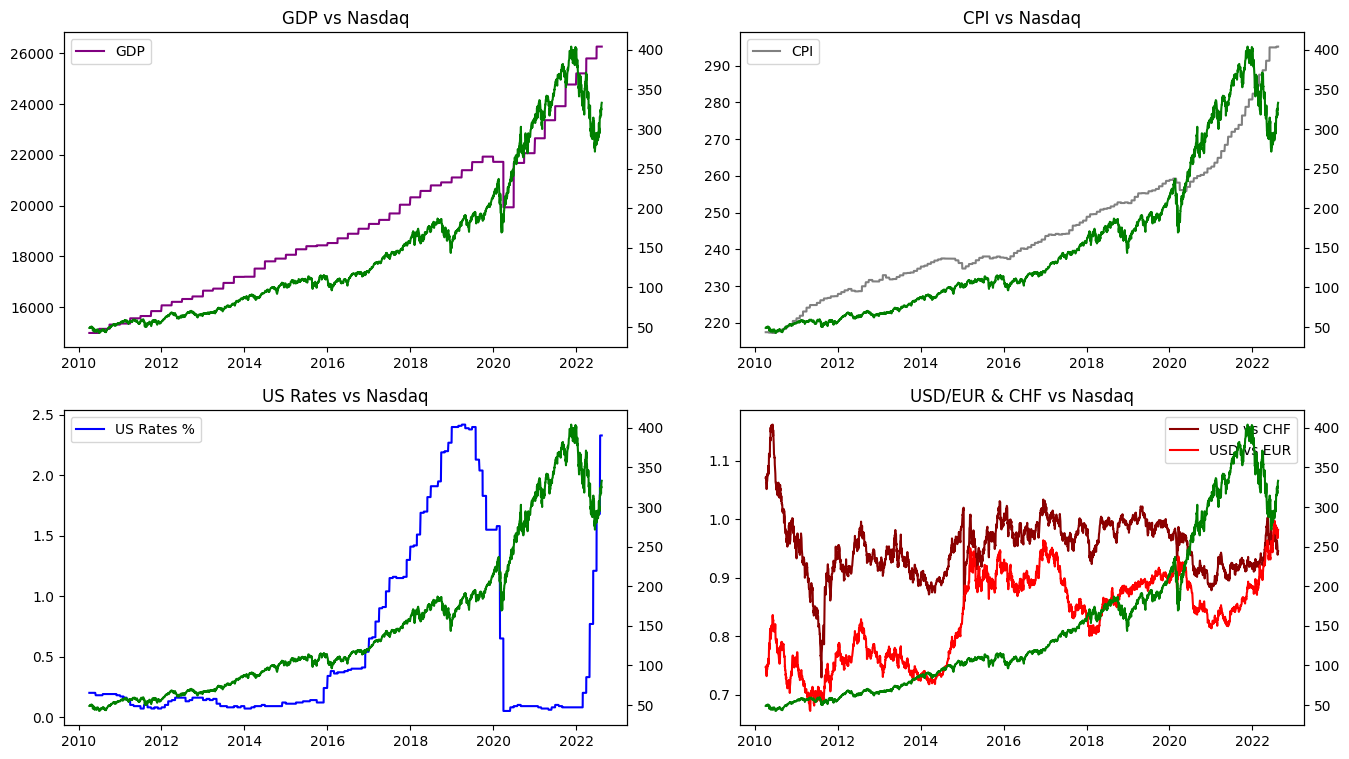

In [58]:
fig, axs = plt.subplots(2,2, figsize=(16, 9))
#GDP
axs[0,0].plot(x_train.date, x_train.GDP, label="GDP", color="purple")
axs[0,0].set_title("GDP vs Nasdaq")
axs[0,0].legend()

axs_spy = axs[0,0].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close"], label="nasdaq", color='g')
#axs_spy.legend()

#US Rates
axs[1,0].plot(x_train.date, x_train["us_rates_%"], label="US Rates %", color="blue")
axs[1,0].set_title("US Rates vs Nasdaq")
axs[1,0].legend()

axs_spy = axs[1,0].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close"], label="nasdaq", color='g')
#axs_spy.legend()

#CPI
axs[0,1].plot(x_train.date, x_train["CPI"], label="CPI", color="grey")
axs[0,1].set_title("CPI vs Nasdaq")
axs[0,1].legend()

axs_spy = axs[0,1].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close"], label="Nasdaq", color='g')
#axs_spy.legend()

#GDP
axs[1,1].plot(x_train.date, x_train.usd_chf, label="USD vs CHF", color="#8B0000")
axs[1,1].plot(x_train.date, x_train['usd_eur'], label="USD vs EUR", color="red")
axs[1,1].set_title("USD/EUR & CHF vs Nasdaq")
axs[1,1].legend()

axs_spy = axs[1,1].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close"], label="Nasdaq", color='g')
#axs_spy.legend()

plt.show()
#plt.plot(x_train['date'], x_train[[col for col in non_asset_columns if col!='date']])

Although we will be developing predictive short term models, it's still interesting to see how currency status, CPI, US Rates, and GDP impact the S&P 500. It appears that GDP has a very strong reolationship to the stock market, as does CPI.

Now that we're done viewing closing prices, let's remove these columns as they will be unecessary.

In [78]:
x_train = x_train.drop([c for c in x_train.columns if re.match(r".*\s(close|volume)$", c) or c in ["CPI", "usd_chf", "usd_eur", "us_rates_%", "GDP"]], axis=1)
x_test = x_test.drop([c for c in x_test.columns if re.match(r".*\s(close|volume)$", c) or c in ["CPI", "usd_chf", "usd_eur", "us_rates_%", "GDP"]], axis=1)
#df = df.drop([col for col in df.columns if re.match(r"(.*\s(high|low|high-low)$)", col)], axis=1)

Our new data is now in relative log-return form.

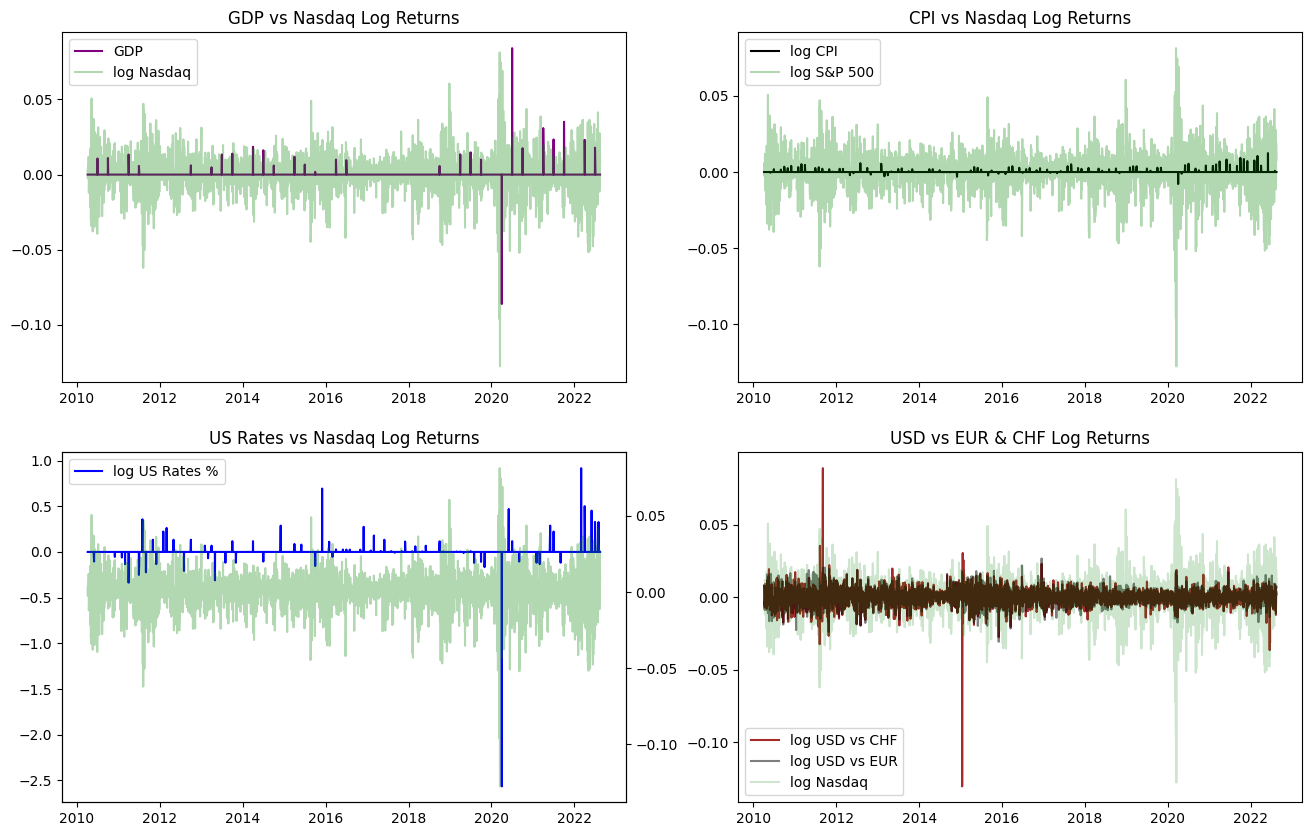

In [87]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
#GDP
axs[0,0].plot(x_train.date, x_train.GDP_shock, label="GDP", color="purple")
axs[0,0].set_title("GDP vs Nasdaq Log Returns")
#axs_spy = axs[0,0].twinx()
axs[0,0].plot(x_train.date, x_train["nasdaq close change"], label="log Nasdaq", color='g', alpha = 0.3)
axs[0,0].legend()


#US Rates
axs[1,0].plot(x_train.date, x_train["us_rates_%_shock"], label="log US Rates %", color="blue")
axs[1,0].set_title("US Rates vs Nasdaq Log Returns")

axs_spy = axs[1,0].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close change"], label="log Nasdaq", color='g', alpha=0.3)
axs[1,0].legend()


#CPI
axs[0,1].plot(x_train.date, x_train["CPI_shock"], label="log CPI", color="black")
axs[0,1].set_title("CPI vs Nasdaq Log Returns")
axs[0,1].plot(x_train.date, x_train["nasdaq close change"], label="log S&P 500", color='g', alpha=0.3)
axs[0,1].legend()

# USD vs EUR & CHF Log Returns
axs[1, 1].plot(x_train.date, x_train['usd_chf_shock'], label="log USD vs CHF", color="brown")
axs[1, 1].plot(x_train.date, x_train['usd_eur_shock'], label="log USD vs EUR", color="black", alpha = 0.5)
axs[1, 1].plot(x_train.date, x_train["nasdaq close change"], label="log Nasdaq", color='g', alpha=0.2)
axs[1, 1].set_title("USD vs EUR & CHF Log Returns")
axs[1, 1].legend()

#plt.tight_layout()
plt.show()

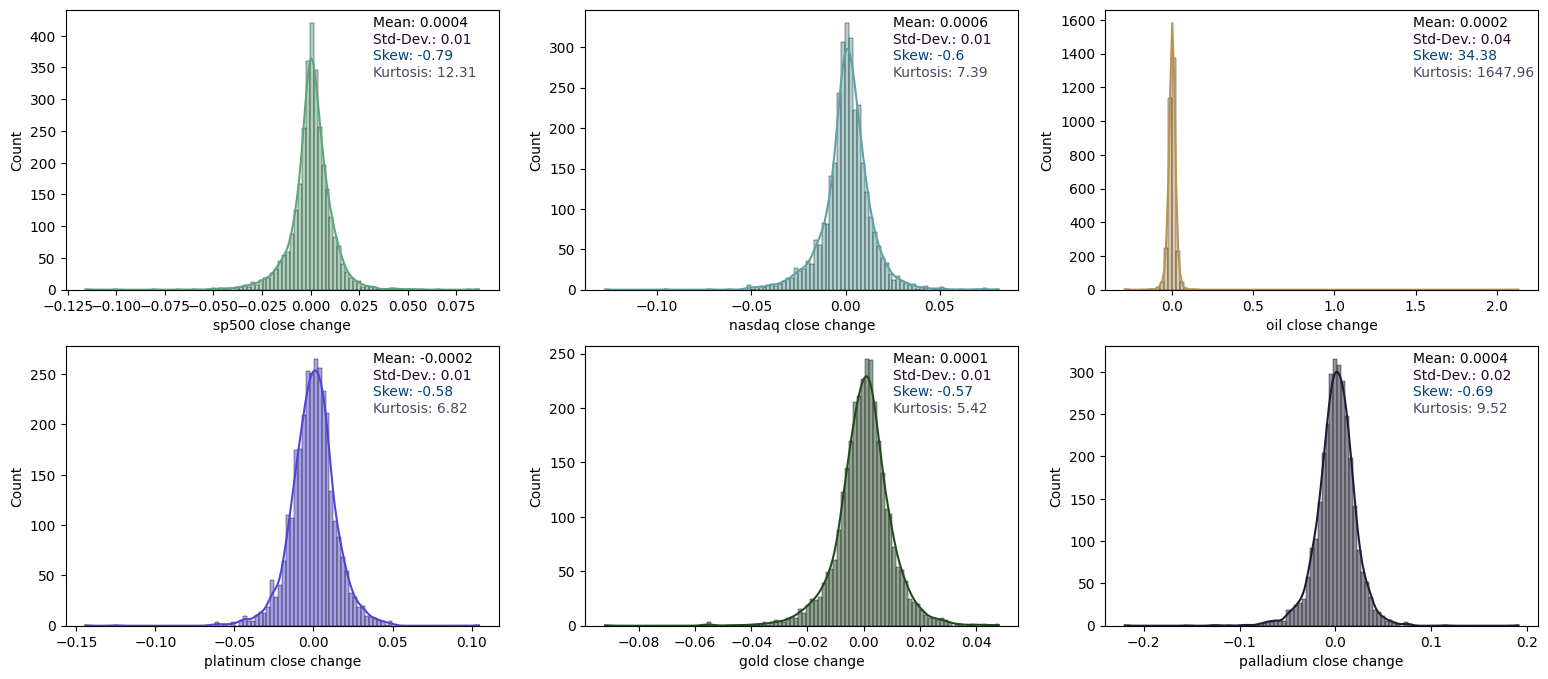

In [90]:
fig, axs = plt.subplots(2, 3, figsize=(19,8), sharex=False)
sns.histplot(x_train['sp500 close change'], kde=True, bins=100, ax = axs[0,0], color="#5EA57E")
sns.histplot(x_train['nasdaq close change'], kde=True, bins=100, ax = axs[0,1], color ="#5EA2A5")
sns.histplot(x_train['oil close change'], kde=True, bins=100, ax = axs[0,2], color="#B99352")
sns.histplot(x_train['platinum close change'], kde=True, bins=100, ax = axs[1,0], color ="#5144D4")
sns.histplot(x_train['gold close change'], kde=True, bins=100, ax = axs[1,1], color="#234923")
sns.histplot(x_train['palladium close change'], kde=True, bins=100, ax = axs[1,2], color ="#1F1D34")

for c in list(zip(enumerate(axs.reshape(-1)), ['sp500 close change','nasdaq close change', 'oil close change', 'platinum close change', 'gold close change','palladium close change'])):
    i=c[0][0]
    ax = c[0][1]
    column = c[-1]
    skew = np.round(x_train[column].skew(),2)
    mean = np.round(x_train[column].mean(),4)
    std_dev = np.round(x_train[column].std(),2)
    median = np.round(x_train[column].median(), 2)
    kurtosis = np.round(x_train[column].kurtosis(),2 )
    ax.text(x=0.71, y=0.94, s=f"Mean: {mean}", transform = ax.transAxes, color = 'black')
    ax.text(x=0.71, y=0.88, s=f"Std-Dev.: {std_dev}", transform = ax.transAxes, color = '#24042B')
    ax.text(x=0.71, y=0.82, s=f"Skew: {skew}", transform = ax.transAxes, color = '#054270')
    ax.text(x=0.71, y=0.76, s=f"Kurtosis: {kurtosis}", transform = ax.transAxes, color = '#4E4763')

Why use log returns, not % returns for analying returns? Log returns better resemble the underlying nature of compounding. For example, if we had a compounding 10% gain, and a -10% loss, one would be forgiven for assuming the investment neither grew nor shrank. The truth is, however, that the investment will have lost 1% -> [1.1*.9=.99]. If the stock market, hypothetically, had short term growth and shrinkage, but ultimately hovered around the same value (equilibream) at which it started, it would necessarily imply that the growth outweighed the shrinkage (x = positive loss less than 1 and greater than 0. $100 -> $100*(1-x)^n = $v -> $v * 1/((1-x)^n) -> $100). Where 1/(1-x) > (1+x). 

What can we tell from the log return distributions? S&P 500, NASDAQ, Palladium, Gold, and Platinum seem to have very similar normal-esque distributions. Oil returns are either extremely stable or extremely volatile relative to other assets. This justifies its massive kurtosis. The S&P has a higher kurtosis when consider all non-oil assets, meaning that days with small returns/losses and relatively massive returns/losses are more frequent than in competitors. All log returns are left skewed except for oil. This implies more extreme losses in the left tails relative to gains in the right tails. What asset would be best to hold? These patterns will not necessarily continue into the future, but the NASDAQ has the highest mean return, so it would be a solid pick.

Looking at the cause of this outlier shows us that the shock happens during the pandemic, which makes sense since oil prices were near $0, as suppliers didn't have enough storage to hold the oil. This would make it far easier to have a huge log return, as oil prices rebounded away from $0. We will not remove this data point, but may address it indirectly via regularization

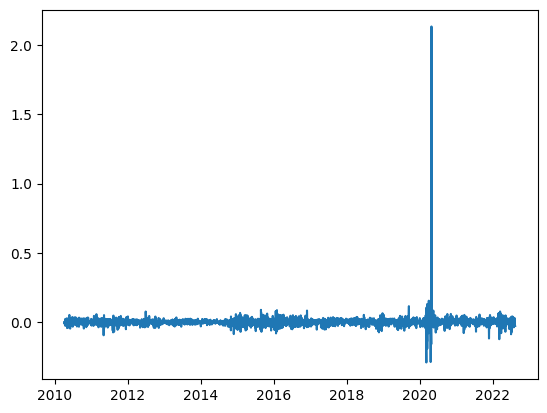

In [92]:
plt.plot(x_train.date, x_train['oil close change'])

Let's take a look at the Pearson (assuming linear) Correlation

<Axes: >

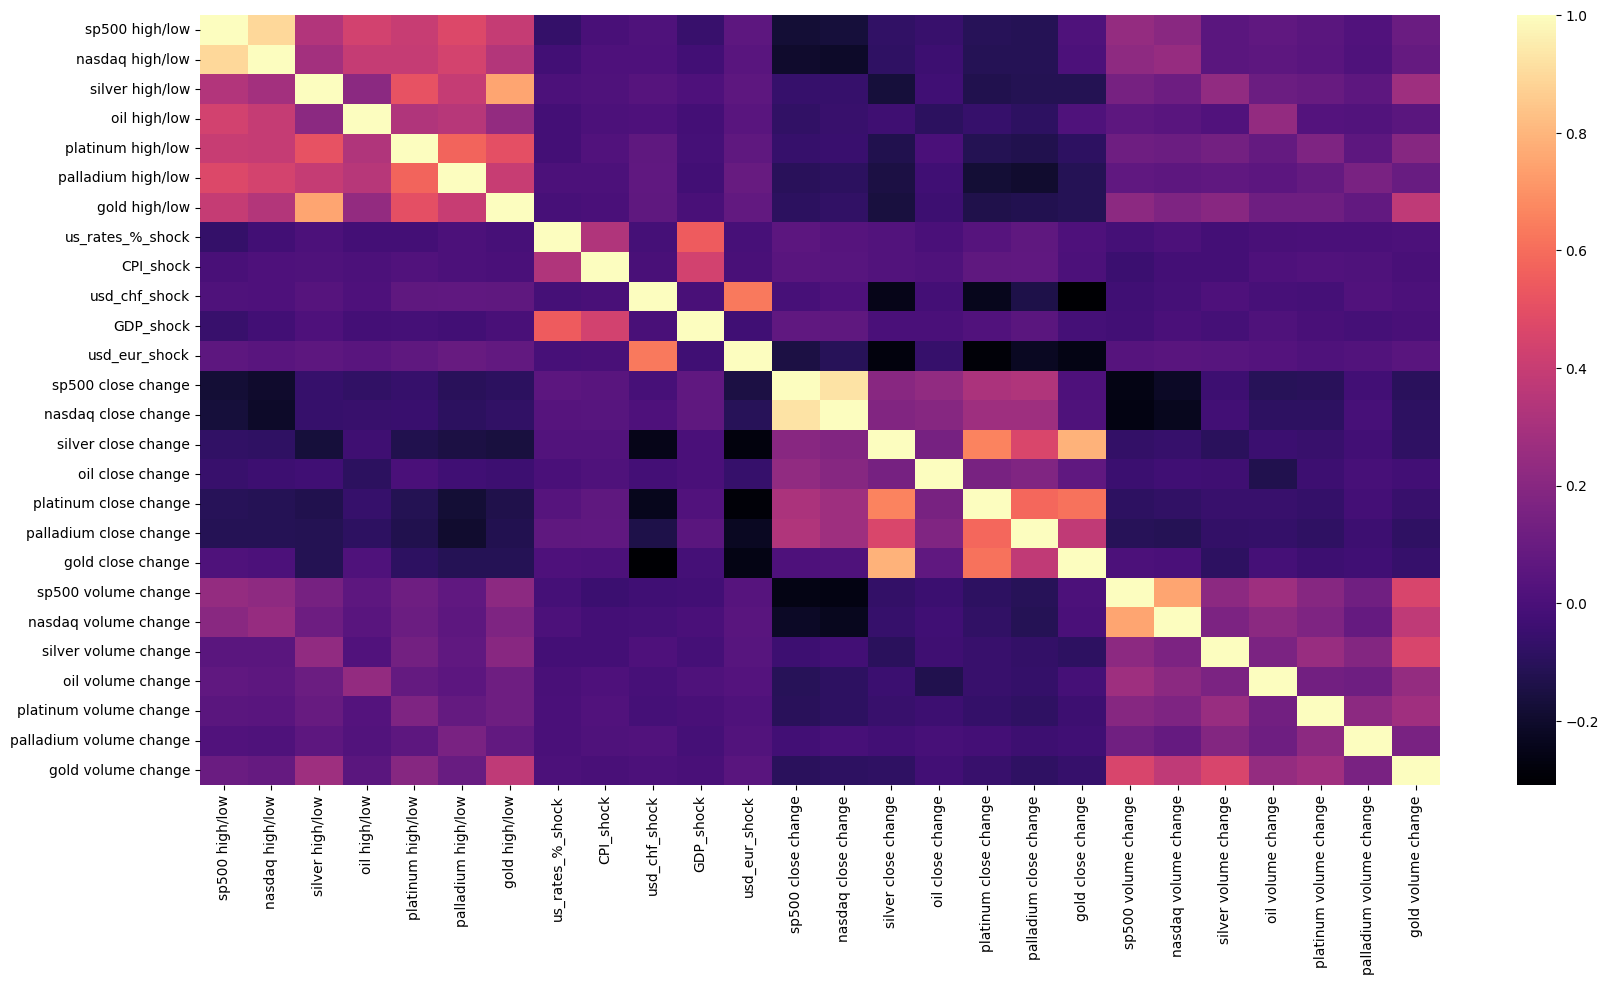

In [94]:
plt.figure(figsize=(20,10))
correlation = x_train[[col for col in x_train.columns if col != 'date']].corr()
sns.heatmap(correlation, cmap='magma')

What can we see from this correlation? The difference in high vs low of the previous 24 hours does not correlate to the returns of the same asset.
#### - The S&P 500 returns are fairly positively correlated to the NASDAQ returns. 
#### - Gold is modestly intertwined with silver
#### - US Rate changes are relatively positively correlated to CPI changes.
#### - USD vs EUR, expectedly, is somewhat positively correlated to USD vs CHF

What does the return distribution look like of each?

Now that we have updated our columns to use log returns, we must not fall into the trap of standardizing columns... Not yet. Unless we perform backwards-looking data to train on, we should not standardize, as this requires us to know the future at any given date. We will try to implement a rolling window analysis to train/test on later on.

Let's create a target column: That being the log return of the S&P 500 of following day until close. We can choose Nasdaq, Silver, Gold, but for this purpose, we will try to predict the future return of the S&P.

# Model Development and further analysis

Let's see if we can view any relationships between x_train, and x_test

In [95]:
#pairplot_analysis = [col for col in df.columns if "close" not in col]
#pairplot_analysis + "sp500"

In [561]:
#|sns.pairplot(df[pairplot_analysis])

Let's create target columns

Log returns do scale our data to an extent. We choose to not puruse further scaling. This is because our data is time dependent and future average log returns may change, as well as the relationships between assets. However, for the purpose of seeing any relationships in lower dimensions, we will scale prior to reducing the number of dimensions via the PCA method.

In [100]:
scaler = StandardScaler()
x_train.iloc[:,1:] = scaler.fit_transform(x_train.iloc[:,1:])
pca = PCA(n_components=3, svd_solver="auto")
x_train_3D = pca.fit_transform(x_train.iloc[:,1:])
print("Total explained variance: ", np.round(100*np.sum(pca.explained_variance_ratio_),4), "%")

Total explained variance:  37.863 %


In [117]:
x = x_train_3D[:,0]
y = x_train_3D[:,1]
z = x_train_3D[:,2]
color = y_train['nasdaq close change target']

Text(0.5, 0.92, '3D Plot of PCA')

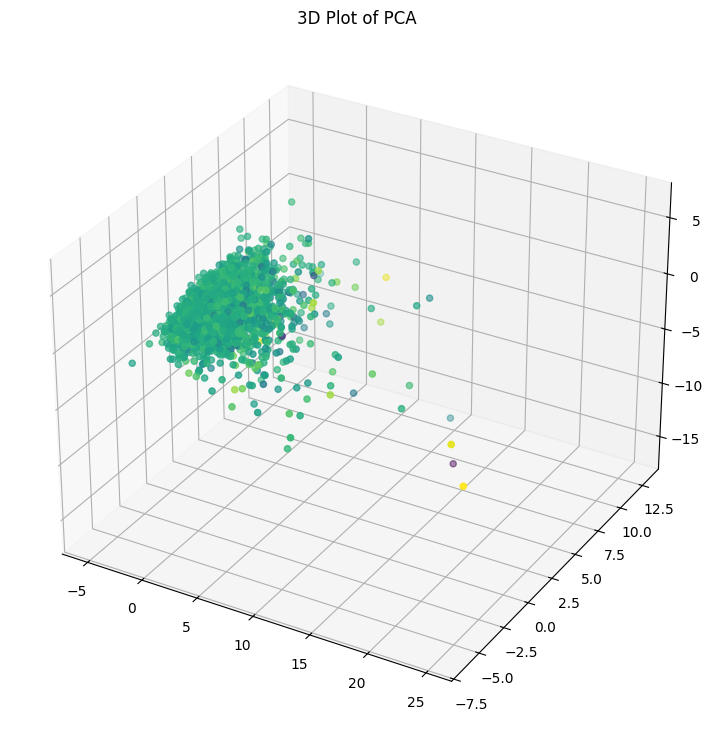

In [118]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=color, cmap='viridis')
ax.set_title('3D Plot of PCA')

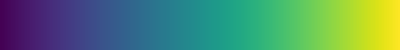

This is strictly for visual perposes. Even though we won't be utilizing PCA later on, we will instead be using SVM kernels in this high dimensional space, it's nice to see that there are some patterns that can possibly be utilized. For example, values that fall far from the typical coordinates after PCA transformation, seem to be more likely to have either fairly large positive or negative returns.

Let's use KFold cross validation to determine which models and parameters are most promising on our training set

In [120]:
def test_model(model):
    fig, axs = plt.subplots(2,3, figsize=(17,10), sharex=False)
    for c in list(zip(enumerate(axs.reshape(-1)), y_col)):
        i=c[0][0]
        ax = c[0][1]
        col = c[-1]
        linear_model = model
        linear_model.fit(x_train.iloc[:,1:], y_train[col])
        y_pred = linear_model.predict(x_train.iloc[:,1:])
        m, b = np.polyfit(y_pred, y_train[col], 1)
        r2 = r2_score(y_pred, y_train[col])
        mae = mean_absolute_error(y_pred, y_train[col])
        mse = mean_squared_error(y_pred, y_train[col])
        ax.plot(y_pred, y_pred * m + b, c="green")
        ax.set_xlabel("predicted")
        ax.set_ylabel("actual")
        ax.scatter(y_pred, y_train[col])
        ax.text(x=0.78, y=0.14, s=f"Slope: {np.round(m,2)}", transform = ax.transAxes, color = 'black')
        ax.set_title(col)
        ax.text(x=0.78, y=0.08, s=f"R2: {np.round(r2)}", transform = ax.transAxes, color = '#24042B')
        ax.text(x=0.78, y=0.02, s=f"MAE: {np.round(mae,3)}", transform = ax.transAxes, color = '#054270')
    #ax.text(x=0.71, y=0.76, s=f"MSE: {np.round(mse,3)}", transform = ax.transAxes, color = '#4E4763')

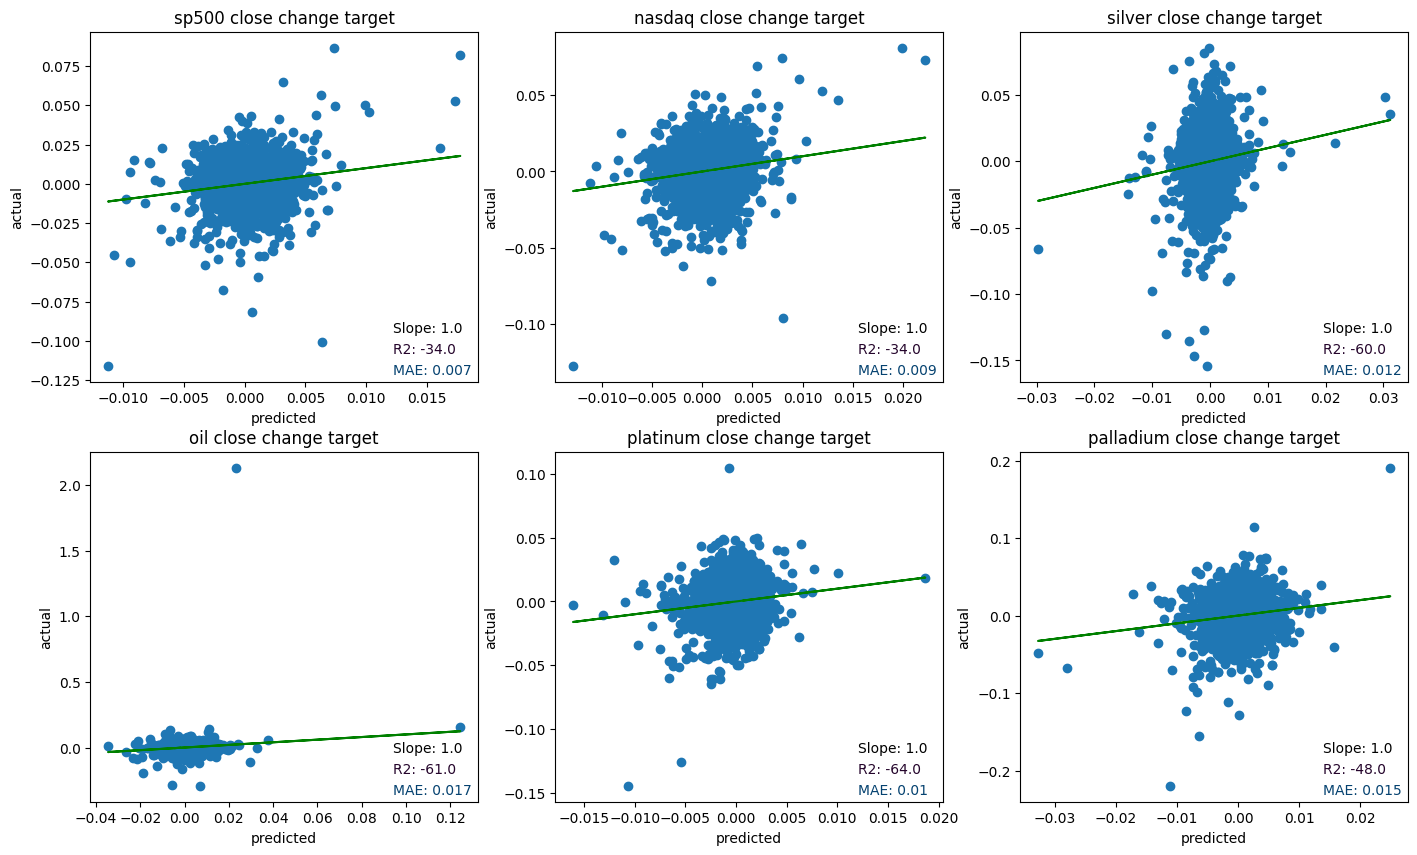

In [121]:
test_model(LinearRegression())

According to the R2 values, all of these simple linear regression models fit very poorly. Let's try a decision tree regressor and build up.

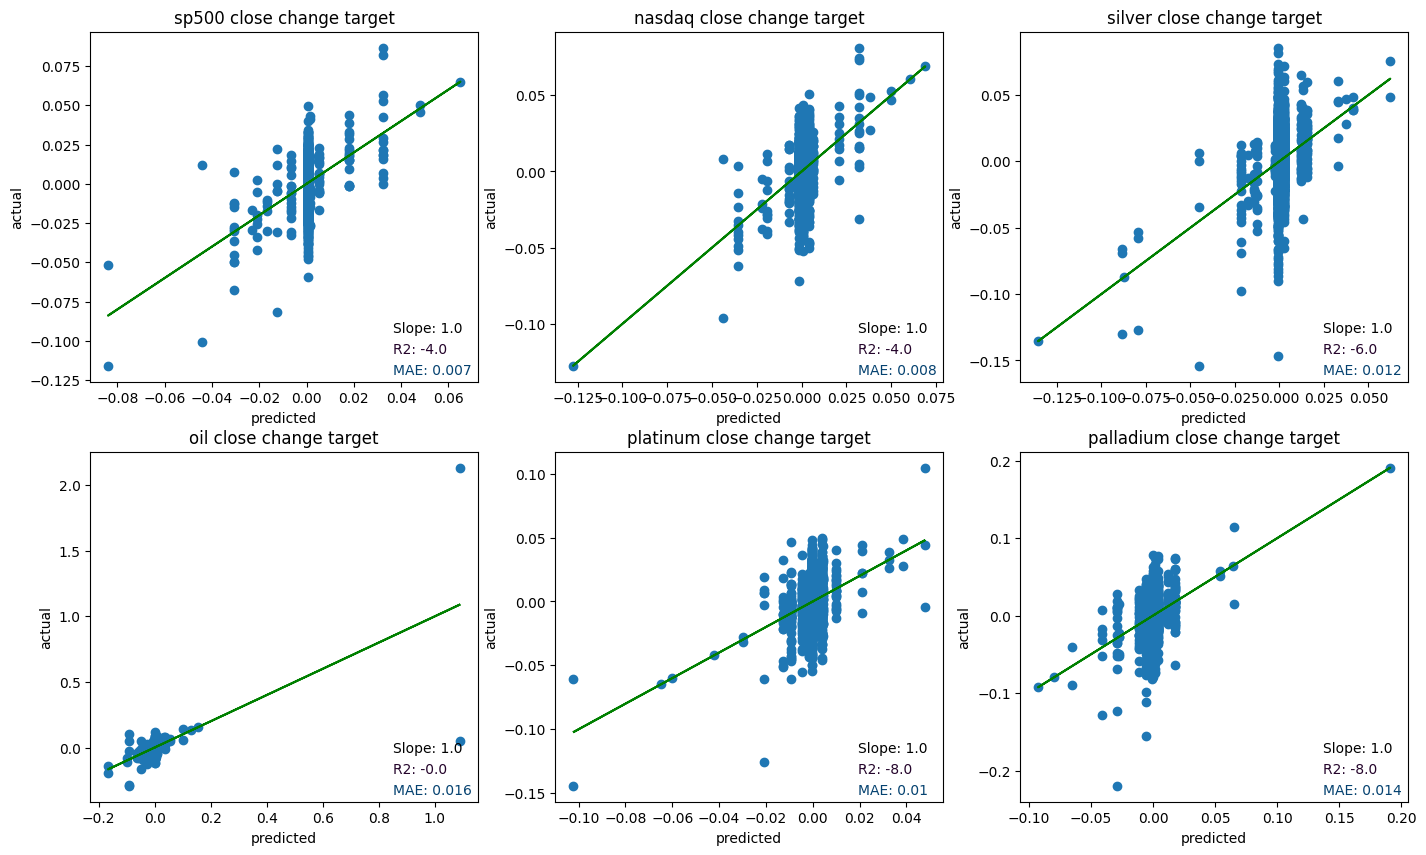

In [122]:
test_model(DecisionTreeRegressor(max_depth=10, min_samples_split=20))

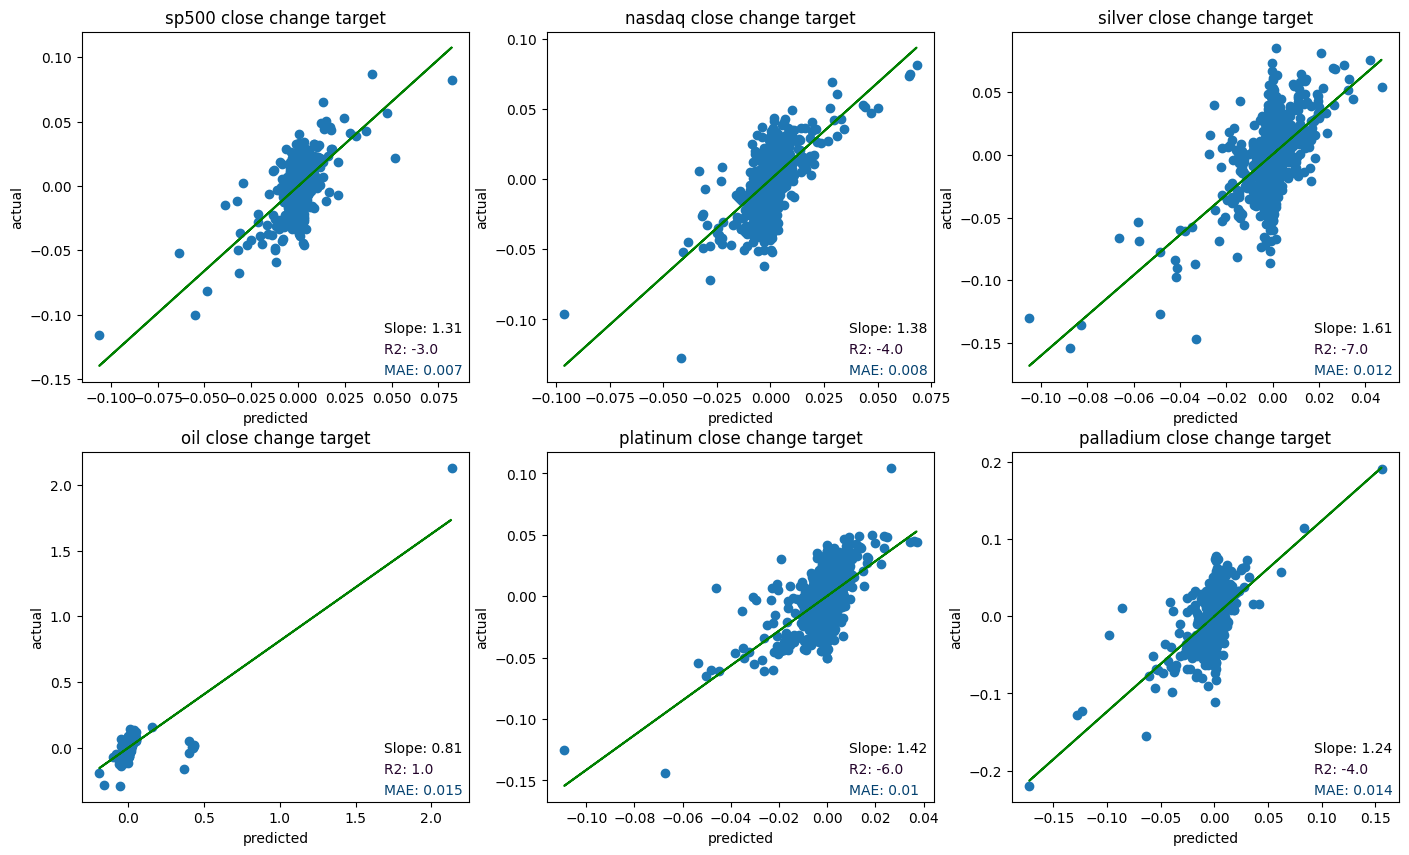

In [124]:
test_model(RandomForestRegressor(n_estimators=5, max_depth=10))

Obvious overfitting

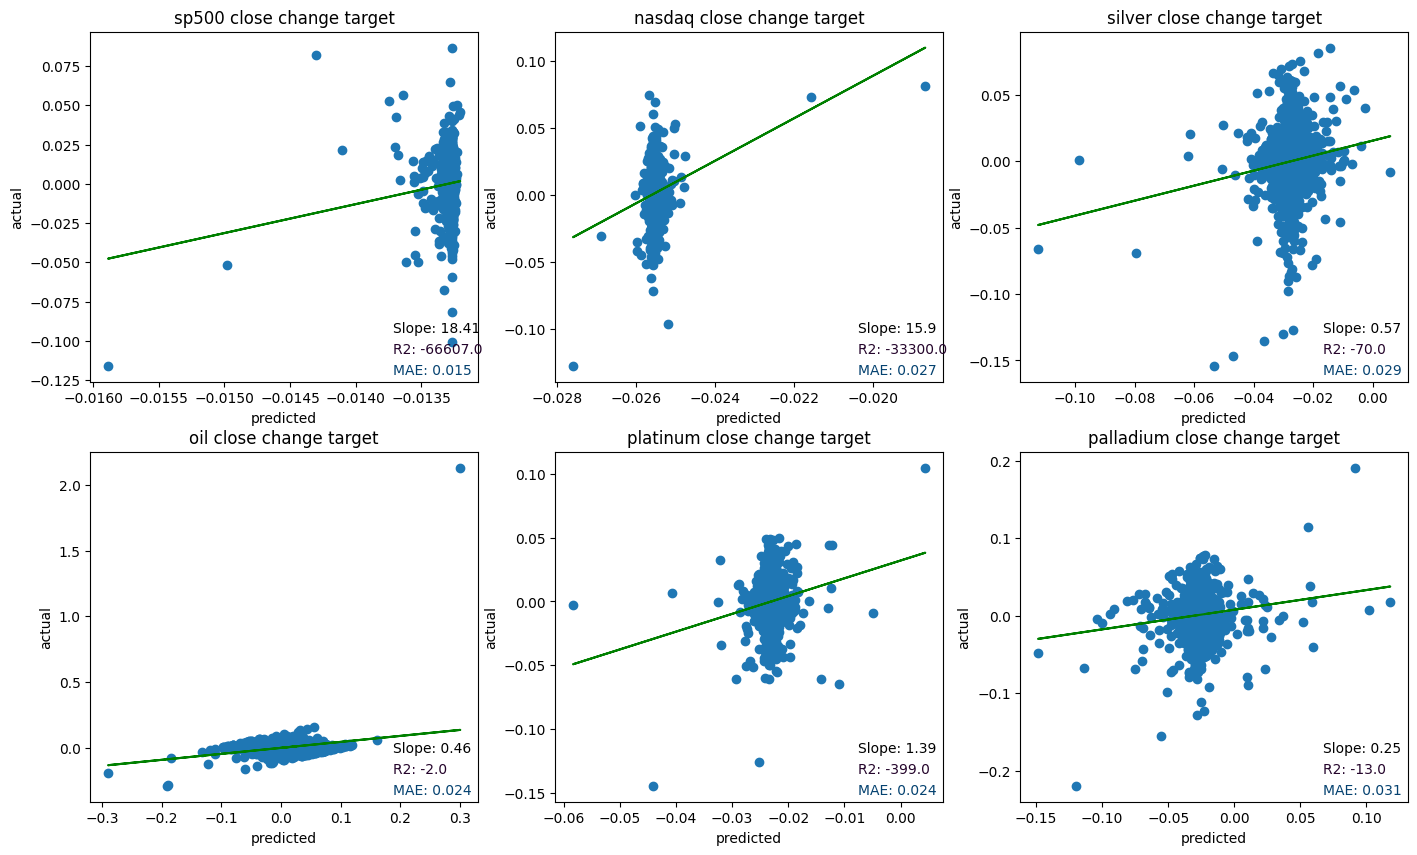

In [137]:
test_model(svm.SVR(kernel='poly', degree=2))

In [139]:
"""fig, axs = plt.subplots(2,3, figsize=(17,10), sharex=False)
for c in list(zip(enumerate(axs.reshape(-1)), y_col)):
    polynomial = PolynomialFeatures(degree = 2)
    x_train_polynomial = polynomial.fit_transform(x_train.iloc[:,1:])
    #x_test_polynomial = polynomial.transform(x_test.iloc[:,1:])
    i=c[0][0]
    ax = c[0][1]
    col = c[-1]
    linear_model = LinearRegression()
    linear_model.fit(x_train_polynomial, y_train[col])
    y_pred = linear_model.predict(x_train_polynomial)
    m, b = np.polyfit(y_pred, y_train[col], 1)
    r2 = r2_score(y_pred, y_train[col])
    mae = mean_absolute_error(y_pred, y_train[col])
    mse = mean_squared_error(y_pred, y_train[col])
    ax.plot(y_pred, y_pred * m + b, c="green")
    ax.set_xlabel("predicted")
    ax.set_ylabel("actual")
    ax.scatter(y_pred, y_train[col])
    ax.text(x=0.78, y=0.14, s=f"Slope: {np.round(m,2)}", transform = ax.transAxes, color = 'black')
    ax.set_title(col)
    ax.text(x=0.78, y=0.08, s=f"R2: {np.round(r2)}", transform = ax.transAxes, color = '#24042B')
    ax.text(x=0.78, y=0.02, s=f"MAE: {np.round(mae,3)}", transform = ax.transAxes, color = '#054270')
#ax.text(x=0.71, y=0.76, s=f"MSE: {np.round(mse,3)}", transform = ax.transAxes, color = '#4E4763')"""

'fig, axs = plt.subplots(2,3, figsize=(17,10), sharex=False)\nfor c in list(zip(enumerate(axs.reshape(-1)), y_col)):\n    polynomial = PolynomialFeatures(degree = 2)\n    x_train_polynomial = polynomial.fit_transform(x_train.iloc[:,1:])\n    #x_test_polynomial = polynomial.transform(x_test.iloc[:,1:])\n    i=c[0][0]\n    ax = c[0][1]\n    col = c[-1]\n    linear_model = LinearRegression()\n    linear_model.fit(x_train_polynomial, y_train[col])\n    y_pred = linear_model.predict(x_train_polynomial)\n    m, b = np.polyfit(y_pred, y_train[col], 1)\n    r2 = r2_score(y_pred, y_train[col])\n    mae = mean_absolute_error(y_pred, y_train[col])\n    mse = mean_squared_error(y_pred, y_train[col])\n    ax.plot(y_pred, y_pred * m + b, c="green")\n    ax.set_xlabel("predicted")\n    ax.set_ylabel("actual")\n    ax.scatter(y_pred, y_train[col])\n    ax.text(x=0.78, y=0.14, s=f"Slope: {np.round(m,2)}", transform = ax.transAxes, color = \'black\')\n    ax.set_title(col)\n    ax.text(x=0.78, y=0.08, s

For our use, let's decide between predicting the next day's S&P or NASDAQ returns, as these targets seem to be the most predictable among the default models. We will also build a sliding machine learning model that is trained on the previous x days to predict the next day's return

We want a model that is highly generalizable, so for this we will use Grid Search cross validation (exhaustive K-Fold search) on 6 sets. The polynomial model seems promising, so we will use polynomial features with a degree of 2 to test linear regression, SVMs, and a decision tree regressor. This allows us to better use potential multiplicative relationships of variables.

We will use Time Series Cross Val. to mimic the true nature of stock analysis (we can't see into the future)
#### Train | Train | Train | Test
#### Train | Train | Test 
#### Train | Test

In [ ]:
{
        'polynomial__degree': [1,2],
        'model': [Lasso()],
        'model__alpha': [0.1, 1, 5, 50]
    },
    #SVRs are less senstitive to outliers (e.g. OIL)
    {
        'model': [svm.SVR()],
        'model__kernel': [ 'rbf', 'poly'],
        'model__degree': [1,2,3],
        'model__epsilon': [.01,.1,.5, 1],
        'model__C': [.10, 1, 10, 40]
    },
    {
        'model': [DecisionTreeRegressor()],
        'model__min_samples_split': [1,5,10],
        'model__min_samples_leaf': [1,5]
    },

In [212]:

#We will be predicting future returns, and as stated before, we assume that the dynamics of assets can change over time, so we will not shuffle, instead we will use TimeSeriesSplit

def grid_for_y_target(target_string):
    pipeline = Pipeline([('polynomial', PolynomialFeatures()), ('model', LinearRegression())])
    param_grid = [
        { 
            'polynomial__degree': [1,2],
            'model': [LinearRegression()]}
        ,{
            'polynomial__degree': [1,2],
            'model': [Ridge()],
            'model__alpha': [0.1, 1, 5]
        },
        #{
        #    'polynomial__degree': [1,2],
        #    'model': [Lasso()],
        #   'model__alpha': [0.001, .004]
        #},
        #SVRs are less senstitive to outliers (e.g. OIL)
        {
            'model': [svm.SVR()],
            'model__kernel': [ 'rbf', 'poly'],
            'model__degree': [1,2,3],
            'model__epsilon': [.07,.1,.5, 1],
            'model__C': [.10, 1, 20]
        },
        {
            'polynomial__degree': [1,2],
            'model': [RandomForestRegressor()],
            'model__n_estimators': [20],
            'model__min_samples_leaf': [10,15]
        }
    ]
    #To set seed for
    time_series_split = TimeSeriesSplit(n_splits = 5)
    grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring = "neg_mean_squared_error", verbose= 1)
    grid_search.fit(x_train.iloc[:,1:], y_train[target_string])
    return grid_search

In [213]:
nasdaq_grid = grid_for_y_target('nasdaq close change target')

Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [218]:
oil_grid = grid_for_y_target('oil close change target')

Fitting 5 folds for each of 84 candidates, totalling 420 fits


Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('model',
                 RandomForestRegressor(min_samples_leaf=15, n_estimators=20))])


/var/folders/vw/nst4t6cs7jb9ygn3ydy2rqwh0000gp/T/ipykernel_46791/1421319773.py:5: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(y_test_pred, y_test[col], 1)


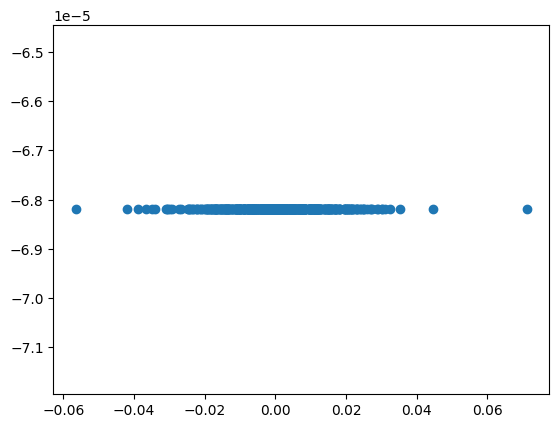

In [214]:
nasdaq_pipe = nasdaq_grid.best_estimator_
print(nasdaq_pipe)
y_test_pred = oil_pipe.predict(x_test.iloc[:,1:])
col ='nasdaq close change target'
m, b = np.polyfit(y_test_pred, y_test[col], 1)
r2 = r2_score(y_test_pred, y_test[col])
mae = mean_absolute_error(y_test_pred, y_test[col])
mse = mean_squared_error(y_test_pred, y_test[col])
ax.plot(y_test_pred, y_test_pred * m + b, c="green")
plt.scatter(y_test['nasdaq close change target'], oil_pipe.predict(x_test.iloc[:,1:]) )

In [223]:
pd.DataFrame(oil_grid.cv_results_).sort_values(by = "mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,...,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.001751,0.000072,0.000594,0.000024,Ridge(),1.0,5.0,NaN,NaN,NaN,...,NaN,"{'model': Ridge(), 'model__alpha': 5, 'polynom...",-1.874549e-04,-6.421944e-04,-3.293435e-04,-1.002280e-02,-0.000591,-2.354636e-03,3.837729e-03,1
4,0.002022,0.000238,0.000665,0.000109,Ridge(),1.0,1.0,NaN,NaN,NaN,...,NaN,"{'model': Ridge(), 'model__alpha': 1, 'polynom...",-1.883001e-04,-6.425140e-04,-3.294092e-04,-1.002333e-02,-0.000592,-2.355137e-03,3.837737e-03,2
2,0.001955,0.000302,0.000639,0.000067,Ridge(),1.0,0.1,NaN,NaN,NaN,...,NaN,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-1.885167e-04,-6.425896e-04,-3.294244e-04,-1.002345e-02,-0.000592,-2.355257e-03,3.837737e-03,3
0,0.004876,0.001953,0.001019,0.000541,LinearRegression(),1.0,NaN,NaN,NaN,NaN,...,NaN,"{'model': LinearRegression(), 'polynomial__deg...",-1.885414e-04,-6.425981e-04,-3.294261e-04,-1.002346e-02,-0.000592,-2.355271e-03,3.837737e-03,4
81,7.933649,5.917572,0.003964,0.000791,RandomForestRegressor(),2.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-1.940122e-04,-6.532616e-04,-3.492466e-04,-1.001493e-02,-0.000626,-2.367526e-03,3.827570e-03,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.011095,0.007444,0.002482,0.000454,SVR(),NaN,NaN,1.0,2.0,0.07,...,NaN,"{'model': SVR(), 'model__C': 1, 'model__degree...",-3.554886e-04,-6.669898e-04,-3.248487e-04,-1.489478e+00,-0.000609,-2.982868e-01,5.955956e-01,80
25,0.012527,0.006641,0.002907,0.000755,SVR(),NaN,NaN,0.1,3.0,0.07,...,NaN,"{'model': SVR(), 'model__C': 0.1, 'model__degr...",-4.336630e-04,-7.066495e-04,-3.213439e-04,-4.220405e+01,-0.000588,-8.441220e+00,1.688142e+01,81
73,0.013201,0.009922,0.002463,0.000782,SVR(),NaN,NaN,20.0,3.0,0.07,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-4.336630e-04,-7.482404e-04,-3.326084e-04,-3.261621e+03,-0.001253,-6.523249e+02,1.304648e+03,82
49,0.010761,0.006625,0.002367,0.000444,SVR(),NaN,NaN,1.0,3.0,0.07,...,NaN,"{'model': SVR(), 'model__C': 1, 'model__degree...",-4.336630e-04,-7.482404e-04,-3.237485e-04,-3.308626e+03,-0.000625,-6.617255e+02,1.323450e+03,83


Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('model', Ridge(alpha=5))])
-283.82183923884867 0.653473470695464


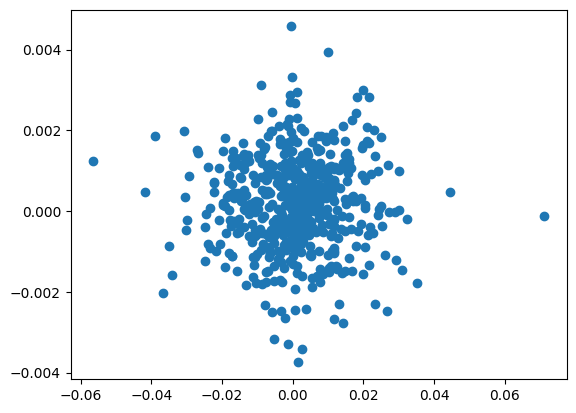

In [224]:
oil_pipe = oil_grid.best_estimator_
print(oil_pipe)
y_test_pred = oil_pipe.predict(x_test.iloc[:,1:])
col ='oil close change target'
m, b = np.polyfit(y_test_pred, y_test[col], 1)
r2 = r2_score(y_test_pred, y_test[col])
mae = mean_absolute_error(y_test_pred, y_test[col])
mse = mean_squared_error(y_test_pred, y_test[col])
ax.plot(y_test_pred, y_test_pred * m + b, c="green")
plt.scatter(y_test['nasdaq close change target'], oil_pipe.predict(x_test.iloc[:,1:]) )
print(m)

In [ ]:
y_test['']

In [ ]:
def calculate_returns(col, threshold):
    actual_returns = np.sum(y_test['oil close change target'])
    y_all = y_test[['oil close change target']].reset_index().drop(columns = ["index"]).merge(prediction, left_index=True, right_index=True)

In [229]:
y_test_pred

array([-7.64183615e-04,  1.23398897e-03,  2.08258725e-04,  1.44314052e-03,
       -1.23542884e-03,  7.35713720e-04,  2.63806497e-04,  4.71863814e-04,
        1.37974452e-03, -1.62229211e-03,  9.15158728e-04, -6.74307140e-05,
        2.94210678e-04,  1.09006233e-03, -1.56190245e-03, -2.66937608e-04,
        1.68554724e-03, -9.03540687e-04,  1.23542793e-03, -2.52893888e-06,
        1.11722965e-03, -4.66068525e-04,  2.70869819e-04, -1.15850529e-04,
        9.02038988e-04, -7.64068176e-05,  4.35185715e-04, -4.97196213e-04,
       -1.21474371e-04,  1.57007175e-03,  8.56389570e-04, -1.10165918e-03,
        1.35145094e-03, -1.45963072e-03, -7.22866248e-04,  5.06790221e-04,
        1.85718444e-03, -1.05596825e-03,  5.81210426e-05,  4.57149680e-03,
       -2.30538584e-03,  3.37349812e-04, -1.91883498e-04, -1.42825495e-03,
        6.82943332e-04, -3.65246706e-04,  2.00728851e-03,  7.16351953e-04,
       -8.86237631e-04,  7.14538761e-04,  7.33302073e-04,  9.83263507e-04,
        1.40645206e-04, -

In [257]:
prediction = pd.DataFrame(y_test_pred, columns = ["test prediction"])
#y_test[['oil close change target']].merge(predicted_values, left_on=None, right_on=None, left_index=False, right_index=False)#, axis=1, ignore_index=True)

In [256]:
predicted_values

,test prediction
0,-0.000764
1,0.001234
2,0.000208
3,0.001443
4,-0.001235
...,...
545,0.000788
546,0.000524
547,-0.000698
548,0.000319


In [262]:
y_all = y_test[['oil close change target']].reset_index().drop(columns = ["index"]).merge(prediction, left_index=True, right_index=True)

In [263]:
y_all

,oil close change target,test prediction
0,0.011306,-0.000764
1,0.029539,0.001234
2,-0.002023,0.000208
3,0.008337,0.001443
4,0.028383,-0.001235
...,...,...
545,0.003034,0.000788
546,-0.017223,0.000524
547,0.012253,-0.000698
548,0.023524,0.000319


In [ ]:
oil_pipe = oil_grid.best_estimator_
plt.scatter(y_test['oil close change target'], oil_pipe.predict(x_test.iloc[:,1:]) )

In [163]:
oil_grid.best_estimator_, oil_grid.best_score_

(Pipeline(steps=[('polynomial', PolynomialFeatures()),
                 ('model',
                  RandomForestRegressor(max_depth=4, min_samples_leaf=25,
                                        n_estimators=25))]),
 -0.0023438338439591123)

In [200]:
#nasdaq_results = pd.DataFrame(nasdaq_grid.cv_results_)
#nasdaq_results.sort_values(by = "rank_test_score", ascending=False).params

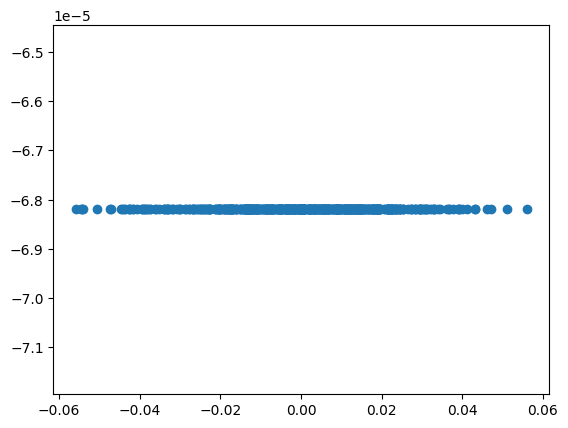

In [199]:
plt.scatter(y_test['oil close change target'], oil_pipe.predict(x_test.iloc[:,1:]) )

Text(0.78, 0.02, 'MAE: 0.009')

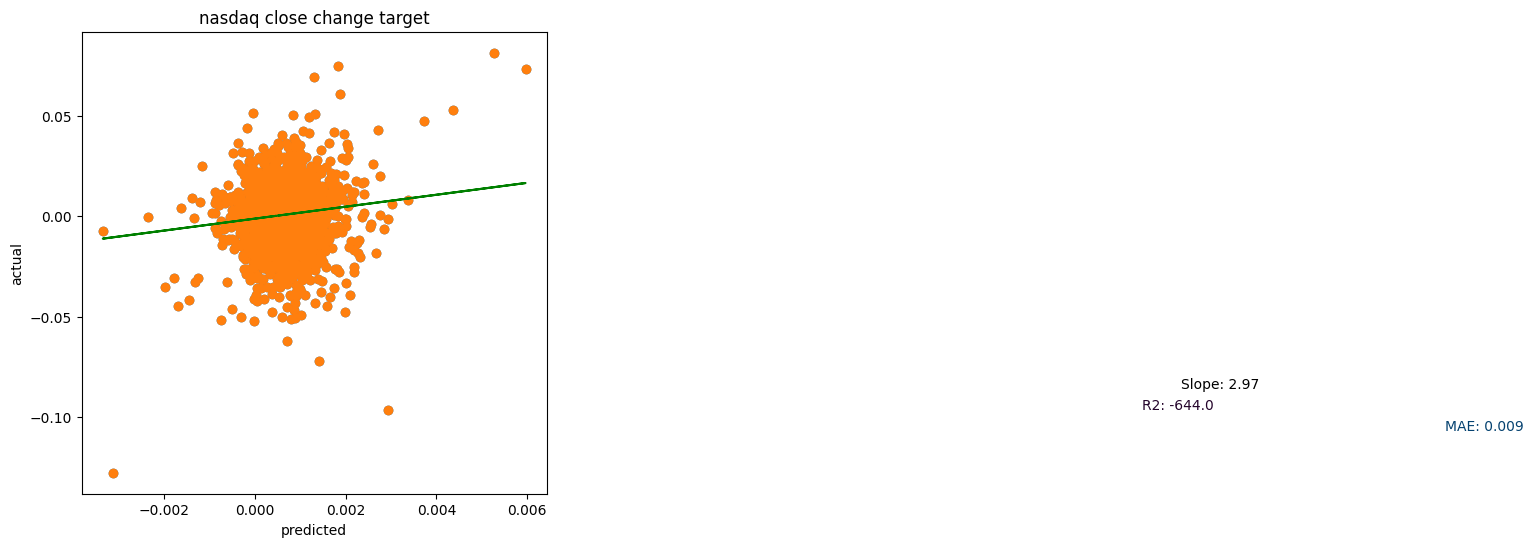

In [195]:
fig, axs = plt.subplots(1,1, figsize=(6,6), sharex=False)

col = 'nasdaq close change target'
nasdaq_pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])
y_pred = nasdaq_pipe.predict(x_train.iloc[:,1:])
plt.scatter(y_pred, y_train[col])
m, b = np.polyfit(y_pred, y_train[col], 1)
r2 = r2_score(y_pred, y_train[col])
mae = mean_absolute_error(y_pred, y_train[col])
mse = mean_squared_error(y_pred, y_train[col])
plt.plot(y_pred, y_pred * m + b, c="green")
axs.set_xlabel("predicted")
axs.set_ylabel("actual")
axs.scatter(y_pred, y_train[col])
axs.text(x=0.10, y=0.14, s=f"Slope: {np.round(m,2)}", transform = ax.transAxes, color = 'black')
axs.set_title(col)
axs.text(x=0, y=0.08, s=f"R2: {np.round(r2)}", transform = ax.transAxes, color = '#24042B')
axs.text(x=0.78, y=0.02, s=f"MAE: {np.round(mae,3)}", transform = ax.transAxes, color = '#054270')

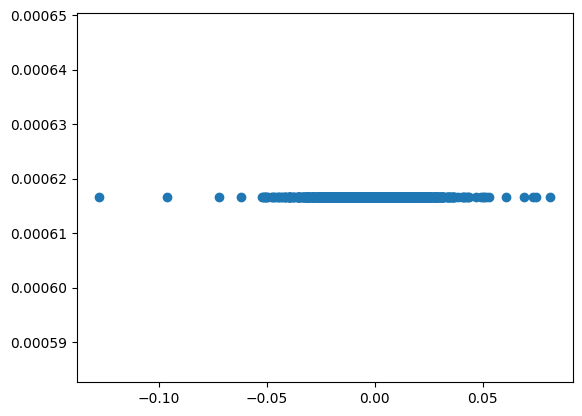

In [183]:
nasdaq_pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])
y_train_pred = nasdaq_pipe.predict(x_train.iloc[:,1:])
plt.scatter( y_train['nasdaq close change target'], y_nasdaq_pred)

In [ ]:
oil_pipe.fit(x_train.iloc[:,1:], y_train['oil close change target'])
oil_train_pred = oil_pipe.predict(x_train.iloc[:,1:])
plt.scatter( y_train['oil close change target'], y_oil_pred)

In [174]:
#nasdaq_results.sort_values(by = "mean_test_score", ascending=False)

In [217]:
pd.DataFrame(nasdaq_grid.cv_results_).tail(9)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,...,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
75,0.005154,0.002109,0.001252,0.000150,SVR(),NaN,NaN,20.0,3.0,0.1,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000915,-0.000332,0.000304,72
76,0.004648,0.001665,0.001429,0.000397,SVR(),NaN,NaN,20.0,3.0,0.5,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,27
77,0.004830,0.001565,0.001551,0.000480,SVR(),NaN,NaN,20.0,3.0,0.5,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,27
78,0.004830,0.001645,0.001276,0.000231,SVR(),NaN,NaN,20.0,3.0,1.0,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,45
79,0.004786,0.001737,0.001258,0.000161,SVR(),NaN,NaN,20.0,3.0,1.0,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,45
80,0.394194,0.264533,0.001901,0.000159,RandomForestRegressor(),1.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000089,-0.000115,-0.000081,-0.000318,-0.000254,-0.000171,0.000096,6
81,6.983018,4.983964,0.002572,0.000331,RandomForestRegressor(),2.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000090,-0.000117,-0.000082,-0.000316,-0.000263,-0.000174,0.000097,8
82,0.324729,0.224015,0.001827,0.000303,RandomForestRegressor(),1.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000084,-0.000117,-0.000082,-0.000309,-0.000255,-0.000170,0.000094,1
83,6.432458,4.596615,0.003234,0.001097,RandomForestRegressor(),2.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000085,-0.000116,-0.000084,-0.000320,-0.000255,-0.000172,0.000097,7


In [ ]:
#best_ridge_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=1)), ('model', Ridge(alpha = 1))])
best_lasso_pipeline_universal = best_model
#worst_linear_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=2)), ('model', LinearRegression())])

for pipe in [best_ridge_pipeline, best_lasso_pipeline_universal, worst_linear_pipeline]:
    pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])

In [805]:
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
results_all = grid_search.cv_results_

print("The best model is: ",grid_search.best_estimator_, " with score: ", best_score)
print(results_all)

The best model is:  Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('model', Lasso(alpha=0.1))])  with score:  -0.00016331357481034797
{'mean_fit_time': array([4.64101632e-03, 1.91640774e-01, 1.41982237e-03, 1.65402492e-02,
       1.34444237e-03, 2.56327788e-02, 2.15466817e-03, 2.51572132e-02,
       1.37432416e-03, 1.55164401e-02, 1.34746234e-03, 5.06464640e-03,
       1.34511789e-03, 5.56719303e-03, 1.34098530e-03, 5.26801745e-03,
       1.26051903e-03, 5.69911798e-03, 2.21148133e-01, 1.68893735e-01,
       1.31193519e-01, 5.94683488e-03, 8.30586751e-03, 7.46019681e-03,
       4.84379133e-03, 4.44225470e-03, 4.08601761e-03, 4.03678417e-03,
       4.08518314e-03, 3.93235683e-03, 2.17697620e-01, 1.23833537e-01,
       1.46321972e-01, 3.82653872e-03, 3.86869907e-03, 4.23713525e-03,
       4.52733040e-03, 4.98016675e-03, 5.07593155e-03, 3.93803914e-03,
       4.09928958e-03, 3.65360578e-03, 2.03480323e-01, 1.43048803e-01,
       1.74015403e-01, 3.81882985e-

In [784]:
test_results = pd.DataFrame(results_all)

In [802]:
print(test_results.query("rank_test_score < 15")[['param_model', 'params']])
params = test_results.query("rank_test_score < 5")[ 'params']

           param_model                                             params
0   LinearRegression()  {'model': LinearRegression(), 'polynomial__deg...
2              Ridge()  {'model': Ridge(), 'model__alpha': 0.1, 'polyn...
4              Ridge()  {'model': Ridge(), 'model__alpha': 1, 'polynom...
6              Ridge()  {'model': Ridge(), 'model__alpha': 5, 'polynom...
8              Ridge()  {'model': Ridge(), 'model__alpha': 50, 'polyno...
9              Ridge()  {'model': Ridge(), 'model__alpha': 50, 'polyno...
10             Lasso()  {'model': Lasso(), 'model__alpha': 0.1, 'polyn...
11             Lasso()  {'model': Lasso(), 'model__alpha': 0.1, 'polyn...
12             Lasso()  {'model': Lasso(), 'model__alpha': 1, 'polynom...
13             Lasso()  {'model': Lasso(), 'model__alpha': 1, 'polynom...
14             Lasso()  {'model': Lasso(), 'model__alpha': 5, 'polynom...
15             Lasso()  {'model': Lasso(), 'model__alpha': 5, 'polynom...
16             Lasso()  {'model': Lass

Surprisingly, all of the best models seem to be Lasso models. This makes sense as Lasso tends to remove variables that are not important

On second look, the first split gives too much error. Perhaps this is because it is only trained on a relatively small set of data? Let's focus only on the last four splits

In [804]:
test_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004641,0.002939,0.001266,0.000709,LinearRegression(),1.0,NaN,NaN,NaN,NaN,...,"{'model': LinearRegression(), 'polynomial__deg...",-9.488608e-05,-0.000081,-0.000113,-0.000148,-0.000328,-0.000240,-1.674297e-04,8.848748e-05,14
1,0.191641,0.088509,0.001606,0.000265,LinearRegression(),2.0,NaN,NaN,NaN,NaN,...,"{'model': LinearRegression(), 'polynomial__deg...",-4.212783e+17,-0.000443,-0.000838,-0.000458,-0.449907,-0.003843,-7.021305e+16,1.570011e+17,166
2,0.001420,0.000264,0.000478,0.000040,Ridge(),1.0,0.1,NaN,NaN,NaN,...,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-8.979352e-05,-0.000074,-0.000111,-0.000148,-0.000326,-0.000236,-1.642814e-04,8.963495e-05,12
3,0.016540,0.005227,0.001315,0.000157,Ridge(),2.0,0.1,NaN,NaN,NaN,...,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-1.051773e-04,-0.000088,-0.000120,-0.000151,-0.000367,-0.000241,-1.786613e-04,9.776463e-05,22
4,0.001344,0.000169,0.000432,0.000011,Ridge(),1.0,1.0,NaN,NaN,NaN,...,"{'model': Ridge(), 'model__alpha': 1, 'polynom...",-8.927269e-05,-0.000073,-0.000110,-0.000149,-0.000328,-0.000234,-1.638984e-04,9.005215e-05,10


In [818]:
test_results['mean_score_last_5_splits'] = test_results[[f"split{n}_test_score" for n in range(1,6)]].mean(axis = 1)

In [827]:
test_results.sort_values(by = "mean_score_last_5_splits", ascending=False).loc[:,'param_model':'params'].join(test_results.sort_values(by = "mean_score_last_5_splits")[['mean_score_last_5_splits']])

,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,param_model__kernel,param_model__min_samples_leaf,param_model__min_samples_split,params,mean_score_last_5_splits
4,Ridge(),1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 1, 'polynom...",-0.000179
6,Ridge(),1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 5, 'polynom...",-0.000179
8,Ridge(),1.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 50, 'polyno...",-0.000179
2,Ridge(),1.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-0.000179
17,Lasso(),2.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Lasso(), 'model__alpha': 50, 'polyno...",-0.000180
...,...,...,...,...,...,...,...,...,...,...,...
116,SVR(),NaN,NaN,10.0,3.0,0.01,poly,NaN,NaN,"{'model': SVR(), 'model__C': 10, 'model__degre...",-0.015483
152,SVR(),NaN,NaN,40.0,3.0,0.01,poly,NaN,NaN,"{'model': SVR(), 'model__C': 40, 'model__degre...",-0.046826
1,LinearRegression(),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': LinearRegression(), 'polynomial__deg...",-0.091098
162,DecisionTreeRegressor(),NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,"{'model': DecisionTreeRegressor(), 'model__min...",NaN


As we can tell, Linear Regression with a polynomial degree of 2 is

In [835]:
best_ridge_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=1)), ('model', Ridge(alpha = 1))])
best_lasso_pipeline_universal = best_model
worst_linear_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=2)), ('model', LinearRegression())])

for pipe in [best_ridge_pipeline, best_lasso_pipeline_universal, worst_linear_pipeline]:
    pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])

In [831]:
#test_results.sort_values(by = "mean_score_last_5_splits").loc[:,'param_model':'params'].join(test_results.sort_values(by = "mean_score_last_5_splits")[['mean_score_last_5_splits']])

In [838]:
ridge_y_preds = best_ridge_pipeline.predict(x_train.iloc[:,1:])
lasso_y_preds = best_lasso_pipeline_universal.predict(x_train.iloc[:,1:])
linear_y_preds = worst_linear_pipeline.predict(x_train.iloc[:,1:])

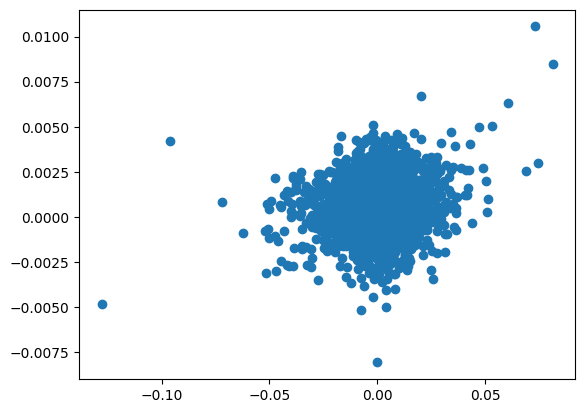

In [839]:
plt.scatter(y_train['nasdaq close change target'], ridge_y_preds)

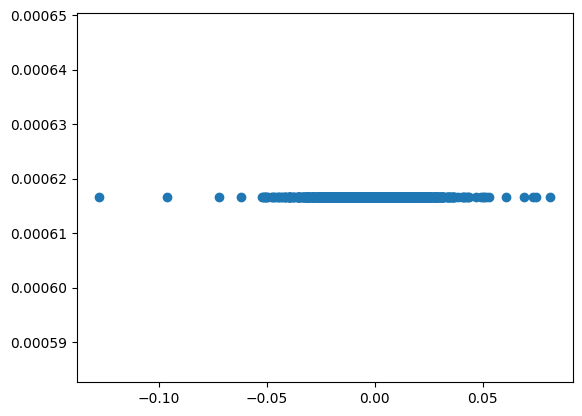

In [842]:
plt.scatter(y_train['nasdaq close change target'], lasso_y_preds)

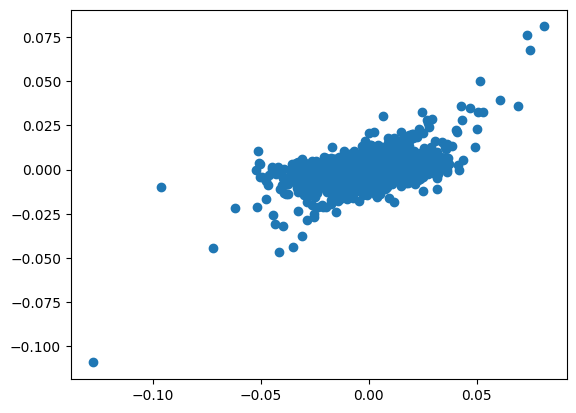

In [843]:
plt.scatter(y_train['nasdaq close change target'], linear_y_preds)

In [ ]:
y_test_pred = best_ridge_pipeline.train()

In [852]:
svm_ensemble = svm.SVR(kernel = 'poly', degree='2')
dtree_ensemble = DecisionTreeRegressor(max_depth=5)
#linear_ensemble.train(ridge)

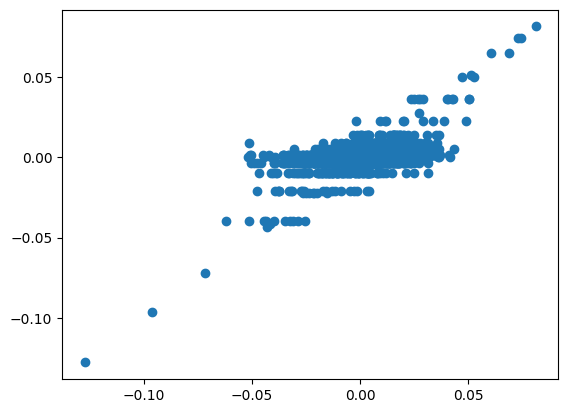

In [855]:
ensemble_input = pd.DataFrame(ridge_y_preds, columns=['ridge']).join(pd.DataFrame(linear_y_preds, columns =['linear']))
dtree_ensemble.fit(ensemble_input, y_train['nasdaq close change target'])
plt.scatter(y_train['nasdaq close change target'], dtree_ensemble.predict(ensemble_input))
#svm_ensemble.train(ensemble_input)

Now the moment of truth, can it

In [860]:
ridge_y_test_preds = best_ridge_pipeline.predict(x_test.iloc[:,1:])
linear_y_test_preds = worst_linear_pipeline.predict(x_test.iloc[:,1:])
ensemble_y_prediction = dtree_ensemble.predict(pd.DataFrame(ridge_y_test_preds, columns = ['ridge']).join(pd.DataFrame(linear_y_test_preds, columns=['linear'])))